In [300]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [449]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 1337
set_seed(seed)

In [5]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [6]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [7]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [8]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_ft_{today}.csv'

In [9]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [10]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
        _timestamp, _open, _high, _low, _close, _volume = ohlcv
        data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [7]:
def volume_features(df):
    df = df.copy()

    df['Date'] = df['Timestamp'].dt.date

    df['ADV'] = df.groupby(['Symbol', 'Date'])['Volume'].transform('mean')

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']

    df['Cum_Volume'] = df.groupby(['Symbol', 'Date'])['Volume'].cumsum()
    df['Cum_Price_Volume'] = df.groupby(['Symbol', 'Date'])['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume']

    df['Price Change'] = df.groupby(['Symbol', 'Date'])['Close'].diff()

    def obv(group):
        obv = (group['Volume'].where(group['Price Change'] > 0, -group['Volume'])
               .where(group['Price Change'] != 0, 0).cumsum())
        return obv

    df['OBV'] = df.groupby(['Symbol', 'Date']).apply(obv, include_groups=False).reset_index(drop=True)

    df.drop(columns=['Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume', 'Price Change'], inplace=True)

    return df

In [14]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [418]:
volume_df = pd.read_csv(volume_df_filename)
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,OBV
0,10000000AIDOGEUSDT,2024-03-28 16:00:00,0.006066,0.006093,0.005933,0.005960,51224500.0,26869925.0,0.005995,-51224500.0
1,10000000AIDOGEUSDT,2024-03-28 17:00:00,0.005960,0.005980,0.005906,0.005940,20305900.0,26869925.0,0.005980,-71530400.0
2,10000000AIDOGEUSDT,2024-03-28 18:00:00,0.005940,0.005989,0.005927,0.005966,14693700.0,26869925.0,0.005977,-56836700.0
3,10000000AIDOGEUSDT,2024-03-28 19:00:00,0.005966,0.006010,0.005945,0.006003,17056200.0,26869925.0,0.005978,-39780500.0
4,10000000AIDOGEUSDT,2024-03-28 20:00:00,0.006003,0.006033,0.005968,0.005983,24093500.0,26869925.0,0.005981,-63874000.0


In [419]:
volume_df.shape[0]

1557032

In [420]:
unique_symbol_count = symbols_df['Symbol'].nunique()
unique_symbol_count

408

In [ ]:
features = ['ADV', 'VWAP', 'OBV']

In [421]:
print("NaN values before imputation:\n", volume_df.isna().sum())

imputer = SimpleImputer(strategy='mean')

volume_df[features] = imputer.fit_transform(volume_df[features])

symbols = volume_df['Symbol'].unique()
n_features = 3

symbol_sequences = []

for symbol in symbols:
    symbol_data = volume_df[volume_df['Symbol'] == symbol][features].to_numpy()
    symbol_sequences.append(symbol_data)

sequence_lengths = [len(seq) for seq in symbol_sequences]

print("Lengths of each sequence:", sequence_lengths)

max_sequence_length = max([len(seq) for seq in symbol_sequences])

print("Max seq:", max_sequence_length)

padded_sequences = [
    np.pad(seq, ((max_sequence_length - len(seq), 0), (0, 0)), 'constant', constant_values=0)
    for seq in symbol_sequences
]

pad_sequence_lengths = [len(seq) for seq in padded_sequences]

print("Lengths of each pad sequence:", pad_sequence_lengths)

symbol_sequences = np.array(padded_sequences)

scaler = StandardScaler()
n_symbols, t_time_steps, n_features = symbol_sequences.shape
symbol_sequences = symbol_sequences.reshape(-1, n_features)
normalized_sequences = scaler.fit_transform(symbol_sequences)
normalized_sequences = normalized_sequences.reshape(n_symbols, t_time_steps, n_features)

print("Shape of features:", normalized_sequences.shape)

X = torch.tensor(normalized_sequences, dtype=torch.float32)

X = X.view(X.size(0), -1)

print("X shape", X.shape)

batch_size = 4
dataset = torch.utils.data.TensorDataset(X)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

NaN values before imputation:
 Symbol       0
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
ADV          0
VWAP         9
OBV          0
dtype: int64
Lengths of each sequence: [4320, 2523, 3144, 1974, 4320, 4320, 4320, 4320, 2309, 2790, 4320, 4320, 269, 4320, 4320, 30, 197, 4320, 4320, 4320, 4320, 4320, 4320, 1540, 4320, 4320, 4320, 4320, 4320, 1711, 4320, 4320, 4320, 2478, 4320, 4320, 2167, 127, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 2479, 4320, 4320, 4320, 1513, 4320, 4320, 4320, 4320, 4320, 4320, 1613, 4320, 4320, 3196, 4320, 4320, 4320, 2719, 4320, 4320, 2142, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 3628, 4320, 4320, 4320, 4320, 512, 321, 4320, 4320, 4320, 4320, 4320, 535, 4320, 4320, 4320, 1614, 4320, 4320, 4320, 3319, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4320, 4226, 4320, 1470, 4320, 4320, 4320, 699, 2694, 1831, 4320, 3030, 4320, 4320, 43

In [423]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, output_dim, dropout_prob=0.2):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, feature_dim),
            nn.Tanh(),
        )

        self.residual = nn.Linear(feature_dim, feature_dim)

    def forward(self, x):
        encoded = self.encoder(x)

        decoded = self.decoder(encoded)

        residual_output = self.residual(x)

        output = decoded + residual_output

        return output

    def get_latent(self, x, normalize=True):
        latent = self.encoder(x)

        if normalize:
            latent = F.normalize(latent, p=2, dim=1)

        return latent

In [424]:
def train_autoencoder(model, dataloader, epochs=50, lr=1e-4, device=None, patience=5):
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()

    best_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        running_loss = 0.0

        for _batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)

            optimizer.zero_grad()

            outputs = model(data)

            loss = criterion(outputs, data)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(dataloader)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.8f}")

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered!")
                break

    print("Training Complete")

In [425]:
def extract_embeddings(model, dataloader, device=None):
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    model.eval()

    embeddings = []

    with torch.no_grad():
        for _batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)

            latent = model.get_latent(data)

            embeddings.append(latent.cpu())

    embeddings = torch.vstack(embeddings)

    return embeddings

In [426]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

feature_dim = max_sequence_length * n_features
output_dim = 10
patience = 12
epochs = 1200

print("Feature DIM: ", feature_dim)

model = Autoencoder(feature_dim=feature_dim, output_dim=output_dim)

train_autoencoder(model, dataloader, epochs=epochs, lr=1e-6, device=device, patience=patience)

Feature DIM:  12960
Epoch [1/500], Train Loss: 1.29993209
Epoch [2/500], Train Loss: 1.22336516
Epoch [3/500], Train Loss: 1.14793584
Epoch [4/500], Train Loss: 1.08144849
Epoch [5/500], Train Loss: 1.02200352
Epoch [6/500], Train Loss: 0.96682799
Epoch [7/500], Train Loss: 0.91483583
Epoch [8/500], Train Loss: 0.86696783
Epoch [9/500], Train Loss: 0.82265304
Epoch [10/500], Train Loss: 0.78172214
Epoch [11/500], Train Loss: 0.74530625
Epoch [12/500], Train Loss: 0.71066409
Epoch [13/500], Train Loss: 0.67976269
Epoch [14/500], Train Loss: 0.65046948
Epoch [15/500], Train Loss: 0.62300906
Epoch [16/500], Train Loss: 0.59772598
Epoch [17/500], Train Loss: 0.57531490
Epoch [18/500], Train Loss: 0.55327394
Epoch [19/500], Train Loss: 0.53329609
Epoch [20/500], Train Loss: 0.51406934
Epoch [21/500], Train Loss: 0.49682536
Epoch [22/500], Train Loss: 0.48065369
Epoch [23/500], Train Loss: 0.46499842
Epoch [24/500], Train Loss: 0.45082190
Epoch [25/500], Train Loss: 0.43781936
Epoch [26/500]

In [427]:
embeddings = extract_embeddings(model, dataloader, device=device)

print("Embeddings shape:", embeddings.shape)

embeddings_np = embeddings.numpy()

np.save(emb_filename, embeddings_np)

Embeddings shape: torch.Size([408, 10])


In [434]:
n_clusters = 3

In [450]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(embeddings_np)

k_cluster_labels = kmeans.labels_

print("KMeans cluster labels", len(k_cluster_labels))

KMeans cluster labels 408


In [451]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=n_clusters)
dbscan_labels = dbscan.fit_predict(embeddings_np)

print("DBSCAN cluster labels:", len(dbscan_labels))

DBSCAN cluster labels: 408


In [457]:
embedding_list = [embedding.tolist() for embedding in embeddings]

df = pd.DataFrame({
    'symbol': symbols,
    'embedding': embedding_list,
    'k_cluster': k_cluster_labels,
    'dbscan_cluster': dbscan_labels
})

df['embedding'] = df['embedding'].apply(np.array)

df.head()


,symbol,embedding,k_cluster,dbscan_cluster
0,10000000AIDOGEUSDT,"[-0.3436932861804962, -0.0029159144032746553, ...",0,0
1,1000000BABYDOGEUSDT,"[-0.34004124999046326, 0.001830299966968596, 0...",0,0
2,1000000MOGUSDT,"[-0.4835602343082428, -0.26773905754089355, 0....",1,0
3,1000000PEIPEIUSDT,"[-0.34078431129455566, 0.0013972538290545344, ...",0,0
4,10000COQUSDT,"[-0.5120819807052612, -0.13195854425430298, 0....",2,0


In [458]:
df[df['symbol'] == 'OMGUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
257,OMGUSDT,"[-0.3422987759113312, 0.0005533581133931875, 0...",0,0


In [454]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=seed)
reduced_embeddings = pca.fit_transform(embeddings_np)

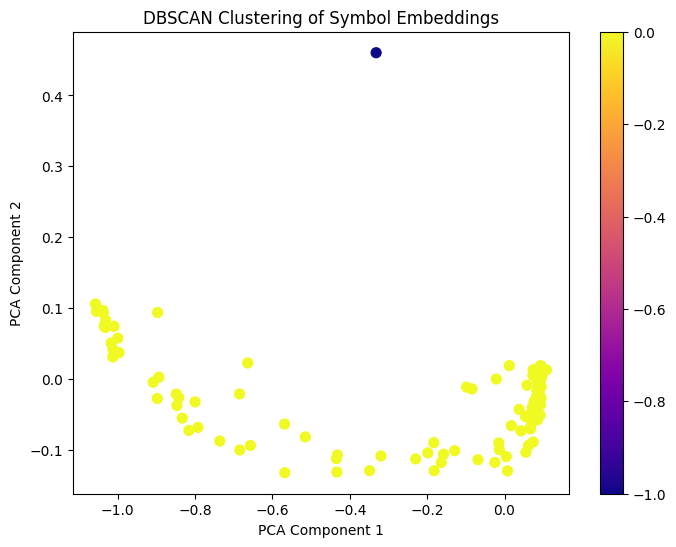

In [455]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='plasma', s=50)
plt.colorbar()
plt.title('DBSCAN Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

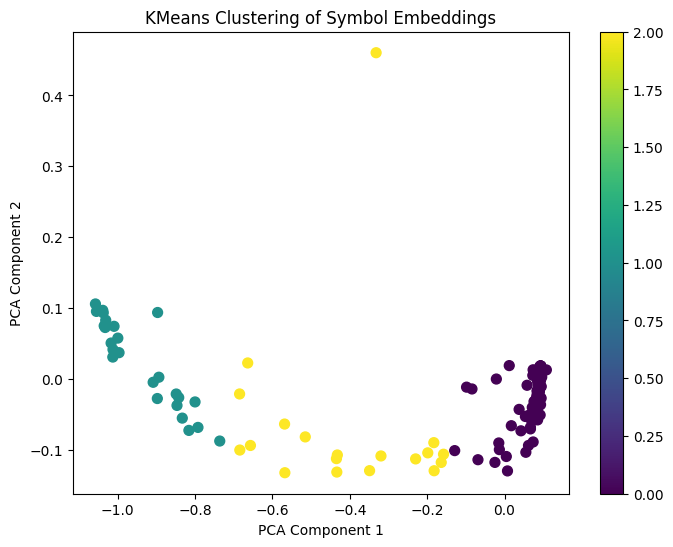

In [456]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=k_cluster_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('KMeans Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()